<h1 style="text-align: center;">Gradient Descent Without Backpropagation</h1>
<h4 style="text-align: center;">Author: Ignacio &Aacute;vila Reyes</h4>


# Introduction


Using backpropagation to compute gradients of functios in order to design machine learning has been the order of the day for a long time.

Here we present an alternative method which is called **Forward Gradient** and its main advantage is computing the gradient during the forward step. Roughly speaking, this is an unbiased estimate of the gradient that permits us to entirely remove the backward step during the training of a neural network.

Let's explain briefly each one of the methods:


# Getting in touch with the code


## Forward Mode

Given a function $f:\mathbb{R}^n\longrightarrow\mathbb{R}^m$ and the values $\theta\in\mathbb{R}^n$, $v\in\mathbb{R}^n$. _Forward Mode_ computes $f(\theta)$ and the jacobian vector product $J_f(\theta)\cdot v$ where $v$ is a vector of perturbations. All of this computed in just the **Forward Step**.

<div align="center"><img alt="Forward Step Scheme" src="./src/images/fwdStep.png"></div>

Firstly, let's get in touch with the method:


In [143]:
import torch
from matplotlib import pyplot as plt
import functorch as fc


In [2]:
# Let's try to use CUDA
DEVICE = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", torch.cuda.get_device_name(DEVICE))


Using NVIDIA GeForce GTX 1050


In [3]:
# We define an input
input = torch.tensor([[5., 10.]]).to(DEVICE)

# Our random vector
v = torch.randn_like(input)
print(v)

# A function

def f(x):
    return x**2


tensor([[1.8783, 0.9117]], device='cuda:0')


In [4]:
# funtorch.jvp(f, input, vector) returns f(input) and the directional gradient of
# "f" in "input" with direction "vector"
value, grad = fc.jvp(f, (input,), (v.to(DEVICE),))
print("Results:", value)
print("Gradient:", grad)


Results: tensor([[ 25., 100.]], device='cuda:0')
Gradient: tensor([[18.7827, 18.2341]], device='cuda:0')


## Reverse Mode

Given a function $f:\mathbb{R}^n\longrightarrow\mathbb{R}^m$ and the values $\theta\in\mathbb{R}^n$, $v\in\mathbb{R}^n$. _Reverse Mode_ computes $f(\theta)$ and the vector-jacobian product $v^T\cdot J_f(\theta)$ where $v$ is a vector of adjoints.

<div align="center"><img alt="Backward Step Scheme" src="./src/images/bckStep.png"></div>

We have already got in touch with this during lab sessions, but let's make some basic calculations:


In [5]:
loss = torch.nn.MSELoss()

# Inputs and expected predictions
input = torch.randn(2, 2, requires_grad=True, device=DEVICE)
target = torch.randn(2, 2, device=DEVICE)

print("Input:", input)
print("Target:", target)

# We define a model with a simple activation layer using the relu
# function
pred = input.relu()
print("Prediction:", pred)
out = loss(input, pred)
print("Output: ", out)
out.backward()

# Gradient
print("Gradient:", input.grad)


Input: tensor([[0.7463, 0.4813],
        [2.2309, 0.1733]], device='cuda:0', requires_grad=True)
Target: tensor([[-1.4445,  1.4968],
        [ 1.4590, -1.4969]], device='cuda:0')
Prediction: tensor([[0.7463, 0.4813],
        [2.2309, 0.1733]], device='cuda:0', grad_fn=<ReluBackward0>)
Output:  tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)
Gradient: tensor([[0., 0.],
        [0., 0.]], device='cuda:0')


# More in depth


## Forward Gradient Method

**Definition.** Given a function $f:\mathbb{R}^n\longrightarrow\mathbb{R}$ we define the "forward gradient" $g:\mathbb{R}^n\longrightarrow\mathbb{R}^n$ as $g(\theta)=(\nabla f(\theta)\cdot v)\hspace{0.1cm}v)$ where $\theta\in\mathbb{R}^n$ is the point at which we are evaluating the gradient and $v\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $v\sim p(v)$ such that $v_i$ components has _zero mean_ and _unit variance_. So that $\nabla f(\theta)\cdot v$ is the directional derivative of $f$ at point $\theta$ in direction $v$.

So each time we evaluate the **forward gradient**, we simply do the following:

- Sample random perturbation vector $v\sim p(v)$
- Evaluate $f(\theta)$ and $\nabla f(\theta)\cdot v$ simoultaneously in the same single forward step without having to compute $\nabla f$ at all in the process.
- Multiply the scalar directional derivative $\nabla f(\theta)\cdot v$ and obtain $g(\theta)$, the forward gradient.

<div align="center"><img alt="Forward Gradient Graph" src="./src/images/graph.png"></div>


# Some simple proofs


Let's now make some simple comprobations that will serve us to ensure that both methods obtain the same results. The only difference is that **Backpropagation** is _less time-consuming_ and **Forward Propagation** is _less memory-consuming_.

For doing this checking, we use the given files [global_optimization_backprop.py](./src/global_optimization_backprop.py) and [global_optimization_fwdgrad.py](./src/global_optimization_fwdgrad.py) that just take a random tensor of size (2,1) and compute the **Backward Propagation** and the **Forward Propagation** respectively with the hyperparameters previously defined in [global_optim_config.yaml](./src/configs/global_optim_config.yaml):

- Random Seed: $42$ _(just to generate the same random tensor in both methods)_
- Learning Rate: $10^{-3}$
- Iterations: $5000$


## Backpropagation


In [6]:
!python .\src\global_optimization_backprop.py


Using  NVIDIA GeForce GTX 1050
Iteration [1/5000], Loss: 1.8800, Time (s): 0.5859
Iteration [200/5000], Loss: 0.0031, Time (s): 0.0010
Iteration [399/5000], Loss: 0.0026, Time (s): 0.0014
Iteration [598/5000], Loss: 0.0022, Time (s): 0.0013
Iteration [797/5000], Loss: 0.0018, Time (s): 0.0014
Iteration [996/5000], Loss: 0.0015, Time (s): 0.0012
Iteration [1195/5000], Loss: 0.0013, Time (s): 0.0012
Iteration [1394/5000], Loss: 0.0011, Time (s): 0.0012
Iteration [1593/5000], Loss: 0.0009, Time (s): 0.0012
Iteration [1792/5000], Loss: 0.0008, Time (s): 0.0012
Iteration [1991/5000], Loss: 0.0007, Time (s): 0.0012
Iteration [2190/5000], Loss: 0.0006, Time (s): 0.0022
Iteration [2389/5000], Loss: 0.0005, Time (s): 0.0015
Iteration [2588/5000], Loss: 0.0004, Time (s): 0.0022
Iteration [2787/5000], Loss: 0.0003, Time (s): 0.0026
Iteration [2986/5000], Loss: 0.0003, Time (s): 0.0014
Iteration [3185/5000], Loss: 0.0002, Time (s): 0.0019
Iteration [3384/5000], Loss: 0.0002, Time (s): 0.0019
Itera

## Forward Propagation


In [7]:
!python .\src\global_optimization_fwdgrad.py


Using  NVIDIA GeForce GTX 1050
Iteration [1/5000], Loss: 1.8800, Time (s): 0.6898
Iteration [200/5000], Loss: 0.0107, Time (s): 0.0020
Iteration [399/5000], Loss: 0.0090, Time (s): 0.0017
Iteration [598/5000], Loss: 0.0060, Time (s): 0.0024
Iteration [797/5000], Loss: 0.0048, Time (s): 0.0016
Iteration [996/5000], Loss: 0.0043, Time (s): 0.0016
Iteration [1195/5000], Loss: 0.0037, Time (s): 0.0017
Iteration [1394/5000], Loss: 0.0023, Time (s): 0.0027
Iteration [1593/5000], Loss: 0.0021, Time (s): 0.0020
Iteration [1792/5000], Loss: 0.0017, Time (s): 0.0017
Iteration [1991/5000], Loss: 0.0015, Time (s): 0.0017
Iteration [2190/5000], Loss: 0.0013, Time (s): 0.0025
Iteration [2389/5000], Loss: 0.0012, Time (s): 0.0017
Iteration [2588/5000], Loss: 0.0010, Time (s): 0.0022
Iteration [2787/5000], Loss: 0.0009, Time (s): 0.0019
Iteration [2986/5000], Loss: 0.0008, Time (s): 0.0022
Iteration [3185/5000], Loss: 0.0006, Time (s): 0.0015
Iteration [3384/5000], Loss: 0.0005, Time (s): 0.0016
Itera

# Real-World Applications


Now that we know how to use these two methods, let's use them with _real-world_ issues. For example, let's use them to build a neural network that classifies the **MNIST dataset**.


### Downloading the MNIST Dataset


In [8]:
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor


def download_mnist():
    train_data = datasets.MNIST(
        root="./src/datasets",
        download=True,
        train=True,
        transform=ToTensor(),
    )

    target_data = datasets.MNIST(
        root="./src/datasets",
        download=True,
        train=False,
        transform=ToTensor()
    )

    return train_data, target_data


In [9]:
# Now let's download the dataset

train_data, target_data = download_mnist()
print("MNIST dataset downloaded")


MNIST dataset downloaded


It's also important to observe the data size and type before starting with the calculations:


In [10]:
print("Training data: ", train_data.data.shape, " ", train_data.data.type())
print("Validation data: ", target_data.data.shape, " ", target_data.data.type())


Training data:  torch.Size([60000, 28, 28])   torch.ByteTensor
Validation data:  torch.Size([10000, 28, 28])   torch.ByteTensor


### Defining a Data Loader

Once we have downloaded the dataset, let's design a **Data Loader** just for preparing the batches for the training.


In [11]:
from torch.utils.data import DataLoader

BATCHSIZE = 128
NUMWORKERS = 8
train_data_loader = DataLoader(
    train_data,
    batch_size=BATCHSIZE,
    num_workers=NUMWORKERS,
    shuffle=True
)


Let's observe how does the batching works:

In [12]:
for inputs, targets in train_data_loader:
    print("Inputs: ", inputs.shape)
    print("Targets: ", targets.shape, " === ", targets)
    break

Inputs:  torch.Size([128, 1, 28, 28])
Targets:  torch.Size([128])  ===  tensor([3, 5, 8, 7, 8, 0, 0, 1, 8, 8, 3, 0, 7, 7, 4, 2, 5, 9, 6, 3, 3, 5, 0, 8,
        3, 7, 8, 8, 9, 2, 3, 1, 4, 3, 7, 9, 0, 9, 4, 3, 0, 6, 9, 1, 8, 1, 3, 0,
        9, 6, 1, 4, 0, 2, 2, 2, 8, 5, 8, 6, 0, 1, 2, 5, 4, 7, 5, 3, 6, 8, 8, 8,
        0, 1, 3, 4, 6, 6, 7, 1, 7, 1, 2, 6, 2, 9, 9, 0, 5, 0, 4, 1, 7, 6, 7, 8,
        8, 3, 8, 6, 0, 3, 1, 1, 2, 5, 1, 6, 7, 2, 7, 1, 2, 4, 0, 6, 3, 8, 7, 4,
        0, 3, 5, 7, 2, 9, 5, 7])


### Building the model

Then we create our Neural Network that inherits `torch.nn`:


In [118]:
from torch import nn

class MultiLayer(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(1)

        self.w1 = nn.Parameter(torch.FloatTensor(28*28, 128).uniform_(-1,1).requires_grad_(True).to(DEVICE))
        self.b1 = nn.Parameter(torch.FloatTensor(128).uniform_(-1,1).requires_grad_(True).to(DEVICE))

        self.w2 = nn.Parameter(torch.FloatTensor(128, 64).uniform_(-1,1).requires_grad_(True).to(DEVICE))
        self.b2 = nn.Parameter(torch.FloatTensor(64).uniform_(-1,1).requires_grad_(True).to(DEVICE))
        
        self.w3 = nn.Parameter(torch.FloatTensor(64, 10).uniform_(-1,1).requires_grad_(True).to(DEVICE))
        self.b3 = nn.Parameter(torch.FloatTensor(10).uniform_(-1,1).requires_grad_(True).to(DEVICE))
        

    def forward(self, input_data) -> torch.Tensor:
        flat_data = self.flatten(input_data)
        x = self.relu(flat_data @ self.w1 + self.b1)
        x = self.relu(x @ self.w2 + self.b2)
        logits = self.softmax(x @ self.w3 + self.b3)
        return logits


And now we define some other necessary functions:

In [180]:
# A function to compute losses
def cross_entropy(targets, predictions):
  return torch.abs(torch.gather(predictions + 1e-15 ,0,targets.reshape(-1,1)).log().mean())

Let's do some proofs:

In [173]:
# We initialize an instance of the previously defined network
mnn = MultiLayer().to(DEVICE)

# We try our model with some first examples (one batch of size BATCHSIZE)
loss_fn = cross_entropy

for inputs, targets in train_data_loader:

    w1, b1, w2, b2, w3, b3 = list(mnn.parameters())

    inputs = inputs.to(DEVICE).requires_grad_(True)
    targets = targets.to(DEVICE)

    predictions = mnn(inputs)

    loss = loss_fn(targets, predictions)
    print("Loss: ", loss)

    grads = torch.autograd.grad(loss,[w1, b1, w2, b2, w3, b3])

    with torch.no_grad():

        print(grads[0].shape)
        print(grads[1].shape)
        print(grads[2].shape)
        print(grads[3].shape)
        print(grads[4].shape)
        print("Grad:", grads[5].shape, " => ", grads[5])

    break



Loss:  tensor(25.2595, device='cuda:0', grad_fn=<NegBackward0>)
torch.Size([784, 128])
torch.Size([128])
torch.Size([128, 64])
torch.Size([64])
torch.Size([64, 10])
Grad: torch.Size([10])  =>  tensor([-7.0394e-02,  7.0365e-02,  1.6250e-23,  2.9309e-05,  2.4350e-38,
         1.8777e-43,  2.1528e-30,  5.6052e-45,  4.9462e-40,  1.2644e-22],
       device='cuda:0')


### Training the model

We now code two training loops:

- Backpropagation Loop: `BackTrain`
- Forward Propagation Loop: `FwdTrain`


In [178]:
import time

def BackEpoch(model, data_loader, loss_fn, learning_rate, device) -> None:

    # Initialize some auxiliar variables
    t0 = time.perf_counter()
    it = 0
    losses = []

    for inputs, targets in data_loader: 

        inputs = inputs.to(device).requires_grad_(True)
        targets = targets.to(device)

        # Start time of iteration
        t2 = time.perf_counter()
        
        # We predict the inputs
        predictions = model(inputs)
        
        # Calculate Loss and Accuracy
        loss = loss_fn(targets, predictions)
        losses.append(loss.item())

        # BackPropagate Loss and Update Weights
        grads = torch.autograd.grad(loss, list(model.parameters()))

        [w1, b1, w2, b2, w3, b3] = list(model.parameters())

        with torch.no_grad():

            # Apply gradients
            w1 -= learning_rate * grads[0]
            b1 -= learning_rate * grads[1]

            w2 -= learning_rate * grads[2]
            b2 -= learning_rate * grads[3]
            
            w3 -= learning_rate * grads[4]
            b3 -= learning_rate * grads[5]           

        t3 = time.perf_counter()

        if it % 100 == 0:
            print(f"Iteration {it:4d}, Loss: {loss:.4f}, It. Time: {t3 - t2:.4f} s")
            
        it += 1

        # We reasign the new values to the parameters of the model:
        mnn.register_parameter("w1",w1)
        mnn.register_parameter("b1",b1)

        mnn.register_parameter("w2",w2)
        mnn.register_parameter("b2",b2)

        mnn.register_parameter("w3",w3)
        mnn.register_parameter("b3",b3)
    
    t1 = time.perf_counter()
    
    plt.plot(losses)
    plt.show()

    print("\nEPOCH RESULTS")
    print(f"Loss: {sum(losses)/len(losses):.4f}")
    print(f"Time: {t1-t0:.4f} s")


def BackTrain(model, data_loader, loss_fn, learning_rate, device, epochs) -> None:
    print("=== === === === === === === === === === === ===")
    print("Using", torch.cuda.get_device_name(device))

    for i in range(epochs):
        print(f"---------------- EPOCH {i+1} -------------------")

        BackEpoch(
            model=model,
            data_loader=data_loader,
            loss_fn=loss_fn,
            learning_rate=learning_rate,
            device=device
        )
        
        print("-------------------------------------------------") 
    print("Training Finished")
    print("=== === === === === === === === === === === ===")


=== === === === === === === === === === === ===
Using NVIDIA GeForce GTX 1050
---------------- EPOCH 1 -------------------
Iteration    0, Loss: 34.5388, It. Time: 0.0052 s
Iteration  100, Loss: 34.5388, It. Time: 0.0021 s
Iteration  200, Loss: 33.5514, It. Time: 0.0025 s
Iteration  300, Loss: 34.5158, It. Time: 0.0020 s
Iteration  400, Loss: 32.2003, It. Time: 0.0022 s


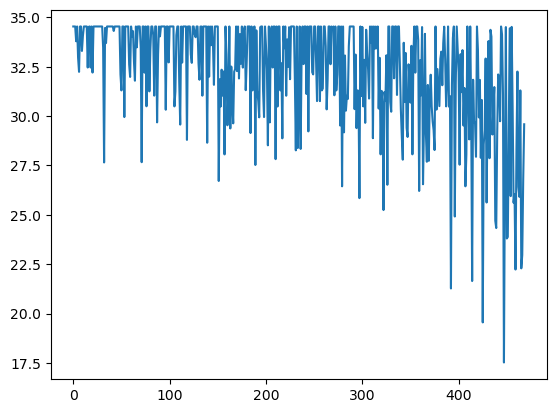


EPOCH RESULTS
Loss: 32.2607
Time: 6.5364 s
-------------------------------------------------
---------------- EPOCH 2 -------------------
Iteration    0, Loss: 24.0142, It. Time: 0.0038 s
Iteration  100, Loss: 21.7793, It. Time: 0.0026 s
Iteration  200, Loss: 5.3517, It. Time: 0.0022 s
Iteration  300, Loss: 0.0000, It. Time: 0.0028 s
Iteration  400, Loss: 0.0001, It. Time: 0.0038 s


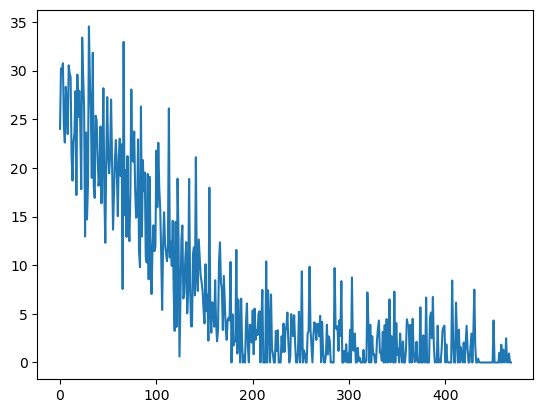


EPOCH RESULTS
Loss: 7.1562
Time: 6.4692 s
-------------------------------------------------
---------------- EPOCH 3 -------------------
Iteration    0, Loss: 3.1883, It. Time: 0.0028 s
Iteration  100, Loss: 0.0000, It. Time: 0.0024 s
Iteration  200, Loss: 4.3041, It. Time: 0.0029 s
Iteration  300, Loss: 0.0000, It. Time: 0.0038 s
Iteration  400, Loss: 0.0000, It. Time: 0.0034 s


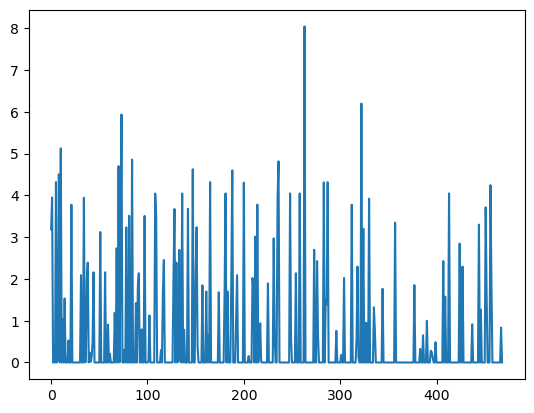


EPOCH RESULTS
Loss: 0.6195
Time: 6.3709 s
-------------------------------------------------
---------------- EPOCH 4 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0026 s
Iteration  100, Loss: 0.0000, It. Time: 0.0028 s
Iteration  200, Loss: 2.2281, It. Time: 0.0036 s
Iteration  300, Loss: 0.0000, It. Time: 0.0029 s
Iteration  400, Loss: 0.0000, It. Time: 0.0031 s


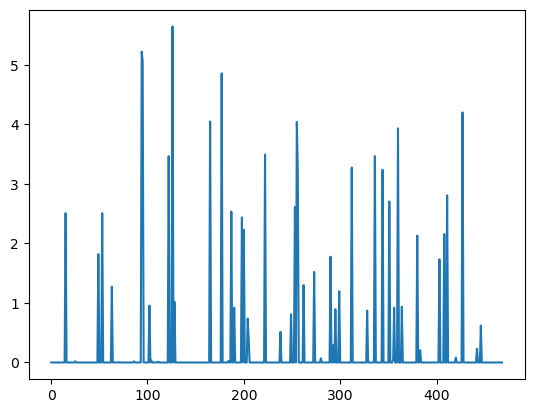


EPOCH RESULTS
Loss: 0.2198
Time: 6.4746 s
-------------------------------------------------
---------------- EPOCH 5 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0020 s
Iteration  100, Loss: 0.0000, It. Time: 0.0036 s
Iteration  200, Loss: 1.3733, It. Time: 0.0043 s
Iteration  300, Loss: 0.0000, It. Time: 0.0029 s
Iteration  400, Loss: 0.0000, It. Time: 0.0021 s


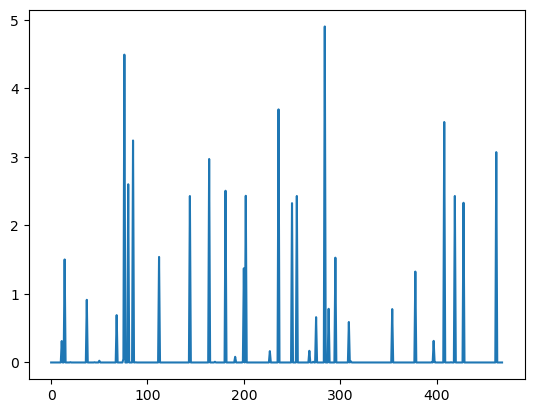


EPOCH RESULTS
Loss: 0.1241
Time: 6.6524 s
-------------------------------------------------
---------------- EPOCH 6 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0024 s
Iteration  100, Loss: 0.0000, It. Time: 0.0036 s
Iteration  200, Loss: 0.0000, It. Time: 0.0022 s
Iteration  300, Loss: 0.0000, It. Time: 0.0030 s
Iteration  400, Loss: 0.0000, It. Time: 0.0037 s


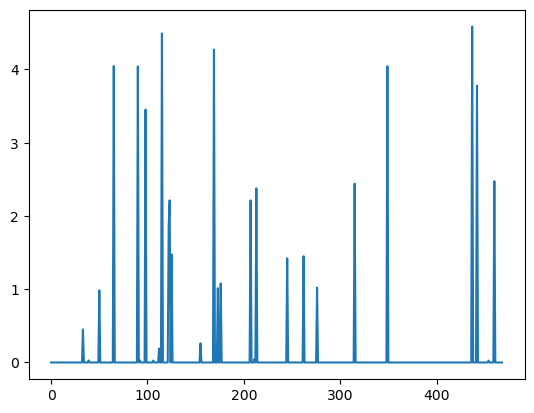


EPOCH RESULTS
Loss: 0.1190
Time: 6.6975 s
-------------------------------------------------
---------------- EPOCH 7 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0036 s
Iteration  100, Loss: 0.0000, It. Time: 0.0032 s
Iteration  200, Loss: 0.0000, It. Time: 0.0021 s
Iteration  300, Loss: 3.1783, It. Time: 0.0025 s
Iteration  400, Loss: 0.0000, It. Time: 0.0024 s


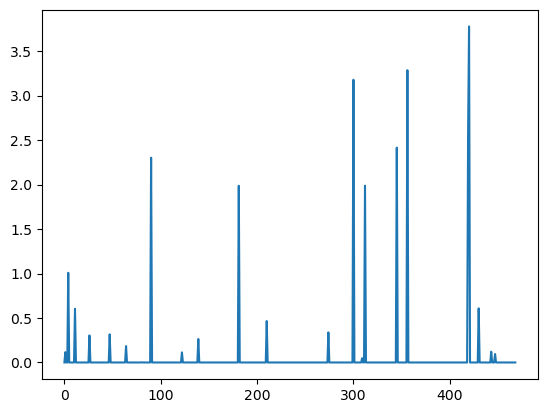


EPOCH RESULTS
Loss: 0.0556
Time: 6.9965 s
-------------------------------------------------
---------------- EPOCH 8 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0051 s
Iteration  100, Loss: 0.0000, It. Time: 0.0031 s
Iteration  200, Loss: 0.0000, It. Time: 0.0027 s
Iteration  300, Loss: 0.0000, It. Time: 0.0025 s
Iteration  400, Loss: 0.0000, It. Time: 0.0031 s


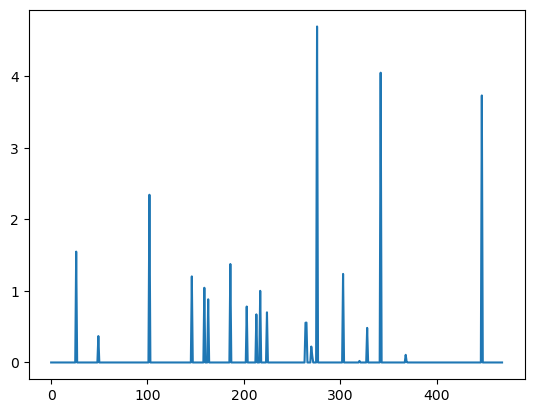


EPOCH RESULTS
Loss: 0.0590
Time: 6.8356 s
-------------------------------------------------
---------------- EPOCH 9 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0044 s
Iteration  100, Loss: 0.0000, It. Time: 0.0020 s
Iteration  200, Loss: 0.2903, It. Time: 0.0029 s
Iteration  300, Loss: 0.0000, It. Time: 0.0024 s
Iteration  400, Loss: 0.0000, It. Time: 0.0019 s


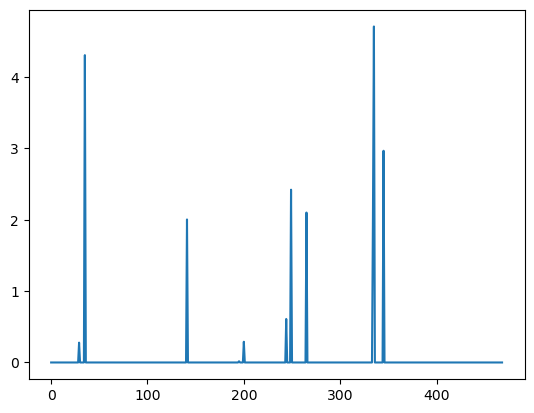


EPOCH RESULTS
Loss: 0.0464
Time: 6.7994 s
-------------------------------------------------
---------------- EPOCH 10 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0024 s
Iteration  100, Loss: 0.0000, It. Time: 0.0030 s
Iteration  200, Loss: 0.0000, It. Time: 0.0024 s
Iteration  300, Loss: 0.0000, It. Time: 0.0040 s
Iteration  400, Loss: 0.0000, It. Time: 0.0028 s


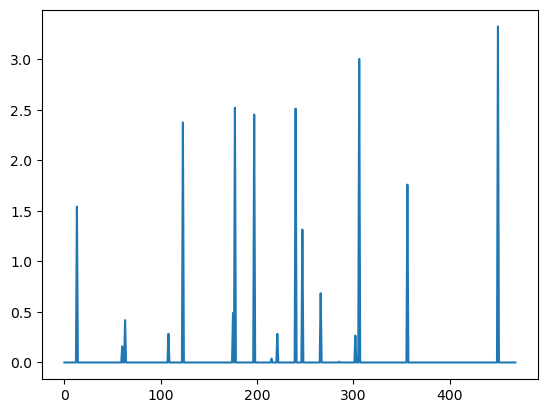


EPOCH RESULTS
Loss: 0.0500
Time: 6.7195 s
-------------------------------------------------
Training Finished
=== === === === === === === === === === === ===


In [183]:
LR = 1e-4
EPOCHS = 10
DEVICE = torch.device(
    f"cuda:0" if torch.cuda.is_available()
    else "cpu"
)

NeuralNetwork = MultiLayer().to(DEVICE)

BackTrain(
    model=NeuralNetwork,
    data_loader=train_data_loader,
    loss_fn=cross_entropy,
    learning_rate=LR,
    device=DEVICE,
    epochs=EPOCHS
)


We can see that in each epoch the loss decreases, just how we wanted. 

Now we are going to evaluate the network testing with the validation data: